In [1]:
import torchvision
from torchvision import datasets, models, transforms
import torch.utils.data as utils
from torch.utils.data import DataLoader,Dataset
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import time
import copy
# from torch.nn import TripletMarginLoss
from torch.optim import lr_scheduler
import os
from PIL import Image, ImageEnhance
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import pandas as pd 
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import f1_score
import PIL.ImageOps    
import random

In [2]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [3]:
class Config():
    train_batch_size = 32
    train_number_epochs = 8

In [4]:
training_dir = "/home/care1e55/study/DBO/project/data/train"
testing_dir = "/home/care1e55/study/DBO/project/data/test"
training_csv="/home/care1e55/study/DBO/project/clean/combined_triplet_train.csv"    
testing_csv="/home/care1e55/study/DBO/project/clean/combined_triplet_test.csv"


In [5]:
RESCALE_SIZE = 224
DATA_MODES = ['train', 'vis', 'test']

In [6]:
pd.read_csv(training_csv).head(2)

,sample
0,1111139/8.png
1,1111139/16.png


In [7]:
class RandomTripletDataset():
    def __init__(self, base_path, transform=None):
        self.transform = transform
        self.genuie = []
        self.forged = []
        self.base_path = base_path
        self.dataframes = []
        files_list = []

        for root, dirs, files in tqdm(os.walk(self.base_path)):
            if files:
                self.dataframes.append([os.path.join(root.split("/")[-1], file) for file in files ])

        dataframes = self.dataframes
        for i in tqdm(range(len(dataframes))):
            if '_forg' not in dataframes[i][0]:
                cur_genuie = dataframes[i]
                for j, dataframe in enumerate(dataframes):
                    if dataframes[i][0].split("/")[0]+"_forg" == dataframes[j][0].split("/")[0]:
                        cur_forg = dataframes[j]
                        break 
                self.genuie.append(cur_genuie)
                self.forged.append(cur_forg)

    def __len__(self):
        return int(len(self.dataframes)//2)
    
    def __getitem__(self, index):
        cur_genuie = self.genuie[index]
        cur_forged = self.forged[index]
        k = 24

        cur_genuie_batch = self.prepare_batch(random.choices(cur_genuie, k = k))
        cur_positive_batch = self.prepare_batch(random.choices(cur_genuie, k = k))
        cur_forged_batch = self.prepare_batch(random.choices(cur_forged, k = k))

        return cur_genuie_batch.squeeze(0), cur_positive_batch.squeeze(0), cur_forged_batch.squeeze(0)
    

    def prepare_batch(self, batch):
        for n, i in enumerate(batch):
            # cur_img = Image.open(os.path.join(self.base_path,i))
            cur_img = Image.open(os.path.join(self.base_path,i))
            # cur_img = cur_img.convert('L')
            # cur_img = ImageEnhance.Contrast(cur_img).enhance(1.5)
            # cur_img = ImageEnhance.Brightness(cur_img).enhance(1.5)
            # cur_img = PIL.ImageOps.invert(cur_img)
            cur_img = cur_img.convert('RGB')
            cur_img.load()
            if self.transform is not None:
                cur_img = self.transform(cur_img)
            if n == 0:
                prepared_batch = cur_img.unsqueeze(0)
            else:
                prepared_batch = torch.cat((prepared_batch, cur_img.unsqueeze(0)), 0)            
        return prepared_batch

    
    def prepare_one(self, one):
        # cur_img = Image.open(os.path.join(self.base_path,one))
        cur_img = Image.open(os.path.join(self.base_path,one))
        # cur_img = cur_img.convert('L')
        # cur_img = PIL.ImageOps.invert(cur_img)
        # cur_img = cur_img.convert('RGB')
        cur_img.load()
        if self.transform is not None:
            cur_img = self.transform(cur_img)
        return cur_img
    

In [8]:
# transform = transforms.Compose([
#   transforms.Resize((RESCALE_SIZE,RESCALE_SIZE)),
#   transforms.ToTensor(),
#   transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#           ])

In [41]:
transform = transforms.Compose([
  # transforms.Pad((50,50), fill=(0,0,0), padding_mode='constant'),
  torchvision.transforms.ColorJitter(brightness=0.3, contrast=0.3),
  # transforms.RandomAffine(
  #   degrees=(-10, 10), 
  #   translate=(0.2,0.2), 
  #   scale=(0.8,1.2), 
  #   shear=None, 
  #   resample=False, 
  #   fillcolor=(0,0,0)),
  transforms.Resize((RESCALE_SIZE,RESCALE_SIZE)),
  transforms.ToTensor(),
  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])

In [15]:
def set_parameter_requires_grad(model):
    for param in model.parameters():
        param.requires_grad = True

In [16]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        self.resnet = models.resnet18(pretrained=False)
        # self.resnet = models.resnet50(pretrained=False)
        set_parameter_requires_grad(self.resnet)
        # self.resnet.avgpool = torch.nn.AdaptiveMaxPool2d(output_size=(1, 1))
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
                nn.Linear(num_ftrs, 1024),
                nn.ReLU(inplace=True),
                nn.Dropout2d(p=0.2),
                nn.Linear(1024, 128),
            )

        
    def forward_once(self, x):
        output = self.resnet(x)
        return output

    def forward(self, input1, input2, input3):
        output1 = self.forward_once(input1.squeeze(0).cuda())
        output2 = self.forward_once(input2.squeeze(0).cuda())
        output3 = self.forward_once(input3.squeeze(0).cuda())
        return output1, output2, output3

    def inference(self, x):
        # self.resnet.eval()
        with torch.no_grad():
            output = self.resnet(x)
            return output

In [17]:
net = SiameseNetwork().cuda()

In [18]:
train_datasdet = RandomTripletDataset(training_dir, transform=transform)

301it [00:00, 13597.19it/s]
100%|██████████| 300/300 [00:00<00:00, 18292.84it/s]


In [19]:
# train_datasdet = RandomTripletDataset(testing_dir, transform=transform)

In [20]:
class TripletLoss(nn.Module):
    """
    Triplet loss
    Takes embeddings of an anchor sample, a positive sample and a negative sample
    """
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative, size_average=True):
        distance_positive = (anchor - positive).pow(2).sum(1)  # .pow(.5)
        distance_negative = (anchor - negative).pow(2).sum(1)  # .pow(.5)
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean() if size_average else losses.sum()

In [21]:
if torch.cuda.is_available():
    print('Yes')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Yes


In [22]:
def fit_epoch(net, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    log_template = "\nIteration {ep:03d} train_loss: {t_loss:0.4f}"  
    
    for i, data in tqdm(enumerate(train_loader,0), total = len(train_loader)):
        img0, img1, img2 = data
        img0, img1, img2 = img0.cuda(), img1.cuda() , img2.cuda()
        optimizer.zero_grad()
        output1, output2, output3 = net(img0, img1, img2)
        loss_contrastive = criterion(output1, output2, output3)
        loss_contrastive.backward()
        optimizer.step()
        running_loss += loss_contrastive.item() * data[0].size(0)
        processed_data += data[0].size(0)
          
    train_loss = running_loss / processed_data

    return train_loss

In [39]:
def train(train_files, net, epochs, batch_size):
    train_dataloader = DataLoader(train_files,
                        shuffle=True,
                        num_workers=4,
                        batch_size=batch_size)

    history = []
   
    opt = optim.AdamW(net.parameters(), lr=0.0005)
    # scheduler = StepLR(opt, step_size=1, gamma=0.5)
    scheduler = StepLR(opt, step_size=2, gamma=0.5)
    # criterion = TripletLoss()
    criterion = nn.TripletMarginLoss(margin = 2.0)

    for epoch in range(epochs):
        print("Epoch:", epoch)
        train_loss = fit_epoch(net, train_dataloader, criterion, opt)
        print("loss:", train_loss)
        
        scheduler.step()
        history.append((train_loss))
                 
    return history

In [42]:
history = train(train_datasdet, net=net, epochs=20, batch_size=1)

Epoch: 0
100%|██████████| 150/150 [01:56<00:00,  1.29it/s]loss: 1.0158180531285081
Epoch: 1

100%|██████████| 150/150 [01:56<00:00,  1.28it/s]loss: 0.9071641231002286
Epoch: 2

100%|██████████| 150/150 [02:09<00:00,  1.16it/s]loss: 0.8999515602427224
Epoch: 3

100%|██████████| 150/150 [02:07<00:00,  1.18it/s]loss: 0.9197271536911528
Epoch: 4

100%|██████████| 150/150 [02:08<00:00,  1.17it/s]loss: 0.9047233715405066
Epoch: 5

 28%|██▊       | 42/150 [00:40<01:45,  1.03it/s]


KeyboardInterrupt: 

In [54]:
torch.save(net.state_dict(), "/home/care1e55/study/DBO/project/models/model_random_sampling_clean.pt")
print("Model Saved Successfully")

Model Saved Successfully


In [55]:
net.load_state_dict(torch.load("/home/care1e55/study/DBO/project/models/model_random_sampling_clean.pt"))

<All keys matched successfully>

In [46]:
transform = transforms.Compose([
# transforms.Pad((50,50), fill=(0,0,0), padding_mode='constant'),
              transforms.Resize((RESCALE_SIZE,RESCALE_SIZE)),
              transforms.ToTensor(),
              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])

In [47]:
class TestDataset():
    
    def __init__(self,training_csv=None,base_path=None,transform=None):
        # used to prepare the labels and images path
        self.training_df=pd.read_csv(training_csv)
        self.training_df.columns =["image1","image2","label"]
        self.base_path = base_path    
        self.transform = transform

    def __getitem__(self,index):
        
        img0 = self.prepare_one(self.training_df.iat[index,0])
        img1 = self.prepare_one(self.training_df.iat[index,1])
            
        return img0, img1 , torch.from_numpy(np.array([int(self.training_df.iat[index,2])],dtype=np.float32))

    def prepare_one(self, one):
        # cur_img = Image.open(os.path.join(self.base_path,one))
        cur_img = Image.open(os.path.join(self.base_path,one))
        # cur_img = cur_img.convert('L')
        # cur_img = ImageEnhance.Contrast(cur_img).enhance(1.5)
        # cur_img = ImageEnhance.Brightness(cur_img).enhance(1.5)
        # cur_img = PIL.ImageOps.invert(cur_img)
        cur_img = cur_img.convert('RGB')
        cur_img.load()
        if self.transform is not None:
            cur_img = self.transform(cur_img)
        return cur_img
    
    def __len__(self):
        return len(self.training_df)

In [52]:
test_dataset = TestDataset("/home/care1e55/study/DBO/project/clean/test_combined_constrative_data.csv", "/home/care1e55/study/DBO/project/data/test/", transform=transform)
test_dataloader = DataLoader(test_dataset, num_workers=6, batch_size=64, shuffle=True)
test_dataset = TestDataset("/home/care1e55/study/DBO/project/clean/train_combined_constrative_data.csv", "/home/care1e55/study/DBO/project/data/train/", transform=transform)
test_dataloader = DataLoader(test_dataset, num_workers=6, batch_size=128, shuffle=True)

In [53]:
net.eval()
for t in np.arange(3.0,4.5,1.0):
    targets = []
    predictions = []
    threshhold = torch.FloatTensor([t]).cuda()
    for i, data in enumerate(tqdm(test_dataloader)):
        x0, x1, label = data
        output1 = net.inference(x0.cuda())
        output2 = net.inference(x1.cuda())
        eucledian_distance = F.pairwise_distance(output1, output2)
        # print(eucledian_distance)
        targets += [int(*i) for i in label.tolist()]
        predictions += [int(i) for i in (eucledian_distance > threshhold).tolist()]
        # break
    # print(targets)
    # print(predictions)
    n_predictions = np.array(predictions)
    n_targets = np.array(targets)
    print(f"{t} acc:", (n_predictions == n_targets).astype('int').sum()/len(n_predictions))
    print(f"{t} f1:", f1_score(n_targets, n_predictions, average='weighted'))

  0%|          | 0/800 [00:00<?, ?it/s]3.0 acc: 0.8002324581965932
3.0 f1: 0.7917577223051887
 34%|███▍      | 275/800 [03:33<06:48,  1.29it/s]


KeyboardInterrupt: 

In [48]:
test_dataset = TestDataset("/home/care1e55/study/DBO/project/clean/test_combined_constrative_data.csv", "/home/care1e55/study/DBO/project/data/test/", transform=transform)
test_dataloader = DataLoader(test_dataset, num_workers=6, batch_size=1, shuffle=True)
# test_dataset = TestDataset("/home/care1e55/study/DBO/project/clean/train_combined_constrative_data.csv", "/home/care1e55/study/DBO/project/data/train/", transform=transform)
# test_dataloader = DataLoader(test_dataset, num_workers=6, batch_size=1, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


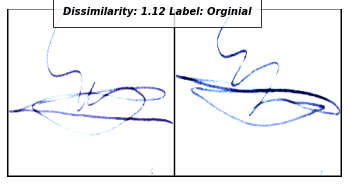

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


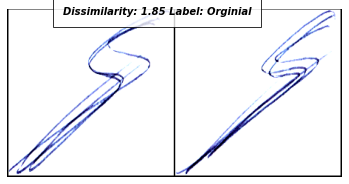

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


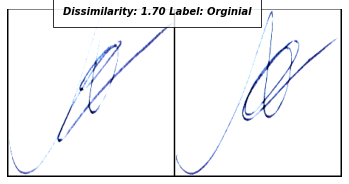

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


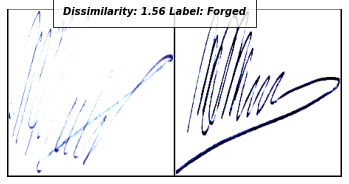

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


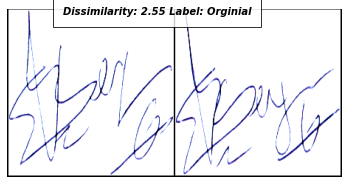

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


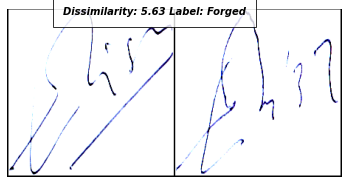

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


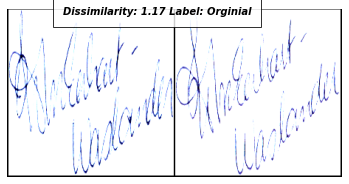

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


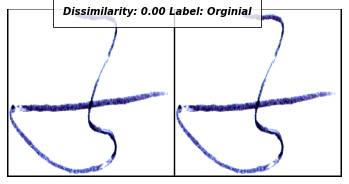

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


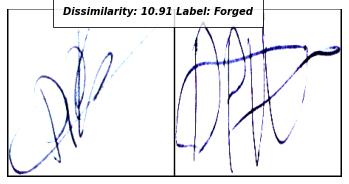

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


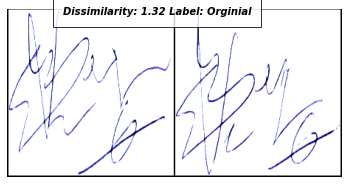

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


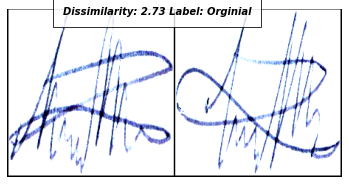

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


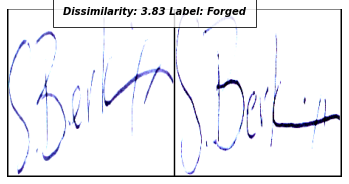

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


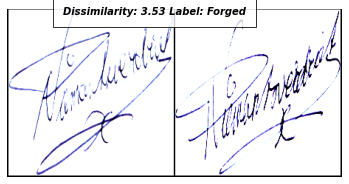

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


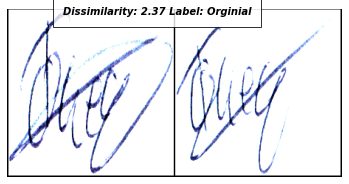

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


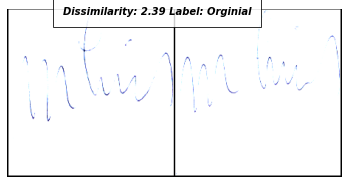

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


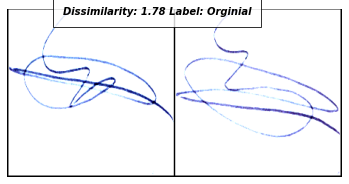

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


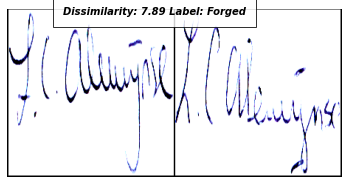

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


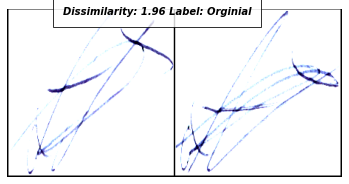

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


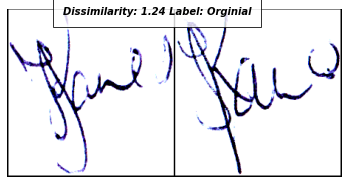

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


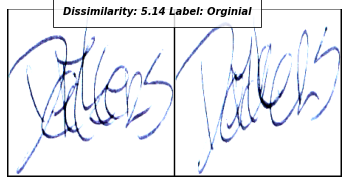

In [51]:
# Print the sample outputs to view its dissimilarity
net.eval()
counter=0
list_0 = torch.FloatTensor([[0]])
list_1 = torch.FloatTensor([[1]])
for i, data in enumerate(test_dataloader,0): 
  x0, x1 , label = data
  concatenated = torch.cat((x0,x1),0)
  output1 = net.inference(x0.to(device))
  output2 = net.inference(x1.to(device))
  eucledian_distance = F.pairwise_distance(output1, output2)
  if label==list_0:
    label="Orginial"
  else:
    label="Forged"
  imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f} Label: {}'.format(eucledian_distance.item(),label))
  counter=counter+1
  if counter ==20:
     break

In [55]:
targets = []
predictions = []
list_0 = torch.FloatTensor([[0]])
list_1 = torch.FloatTensor([[1]])
# threshhold = torch.FloatTensor([50.0]).cuda()
threshhold = torch.FloatTensor([2.0]).cuda()
for i, data in enumerate(tqdm(test_dataloader)):
    x0, x1 , label = data
    output1 = net.inference(x0.to(device))
    output2 = net.inference(x1.to(device))
    eucledian_distance = F.pairwise_distance(output1, output2)
    if label==list_0:
        targets.append(0)
    else:
        targets.append(1)
    
    if eucledian_distance <= threshhold:
        predictions.append(0)
    else:
        predictions.append(1)

100%|██████████| 24093/24093 [05:57<00:00, 67.40it/s]


In [41]:
for j in np.arange(5,8,1):
    targets = []
    predictions = []
    list_0 = torch.FloatTensor([[0]])
    list_1 = torch.FloatTensor([[1]])
    # threshhold = torch.FloatTensor([50.0]).cuda()
    threshhold = torch.FloatTensor([j]).cuda()
    for i, data in enumerate(tqdm(test_dataloader)):
        x0, x1 , label = data
        output1 = net.inference(x0.to(device))
        output2 = net.inference(x1.to(device))
        eucledian_distance = F.pairwise_distance(output1, output2)
        if label==list_0:
            targets.append(0)
        else:
            targets.append(1)
        
        if eucledian_distance <= threshhold:
            predictions.append(0)
        else:
            predictions.append(1)
        n_predictions = np.array(predictions)
    n_targets = np.array(targets)
    print(f"{j} acc:", (n_predictions == n_targets).astype('int').sum()/len(n_predictions))
    print(f"{j} f1:", f1_score(n_targets, n_predictions, average='weighted'))

  0%|          | 0/24093 [00:00<?, ?it/s]2 acc: 0.6068152575436849
2 f1: 0.5824149142651059
  0%|          | 0/24093 [00:00<?, ?it/s]3 acc: 0.6829784584734155
3 f1: 0.6838005008112479
100%|██████████| 24093/24093 [06:03<00:00, 66.33it/s]4 acc: 0.7003694019009671
4 f1: 0.6950986736019261



In [42]:
for j in np.arange(5,8,1):
    targets = []
    predictions = []
    list_0 = torch.FloatTensor([[0]])
    list_1 = torch.FloatTensor([[1]])
    # threshhold = torch.FloatTensor([50.0]).cuda()
    threshhold = torch.FloatTensor([j]).cuda()
    for i, data in enumerate(tqdm(test_dataloader)):
        x0, x1 , label = data
        output1 = net.inference(x0.to(device))
        output2 = net.inference(x1.to(device))
        eucledian_distance = F.pairwise_distance(output1, output2)
        if label==list_0:
            targets.append(0)
        else:
            targets.append(1)
        
        if eucledian_distance <= threshhold:
            predictions.append(0)
        else:
            predictions.append(1)
        n_predictions = np.array(predictions)
    n_targets = np.array(targets)
    print(f"{j} acc:", (n_predictions == n_targets).astype('int').sum()/len(n_predictions))
    print(f"{j} f1:", f1_score(n_targets, n_predictions, average='weighted'))

  0%|          | 0/24093 [00:00<?, ?it/s]5 acc: 0.6841821275889263
5 f1: 0.6590366448596685
  0%|          | 0/24093 [00:00<?, ?it/s]6 acc: 0.6520566139542606
6 f1: 0.5984083286902143
  1%|          | 235/24093 [00:03<05:55, 67.10it/s]


KeyboardInterrupt: 

In [39]:
n_predictions = np.array(predictions)
n_targets = np.array(targets)
(n_predictions == n_targets).astype('int').sum()/len(n_predictions)

0.5036317602623168

In [40]:
f1_score(n_targets, n_predictions, average='weighted')

0.39928514136972276

In [81]:
# TPR
n_predictions.astype('int').sum()/np.logical_and((n_predictions == 1.0),(n_targets == 1.0)).astype('int').sum()

1.7847206888937956

In [82]:
# FPR
n_false_predictions = (np.array(predictions) == 0.0).astype('int')
n_false_targets = (np.array(targets) == 0.0).astype('int')
n_false_predictions.astype('int').sum()/n_false_targets.astype('int').sum()

1.1999682590065068

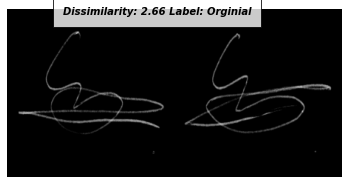

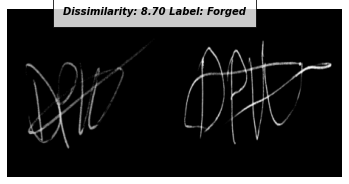

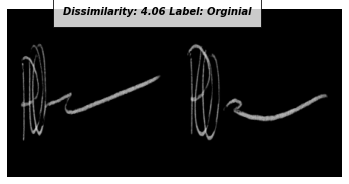

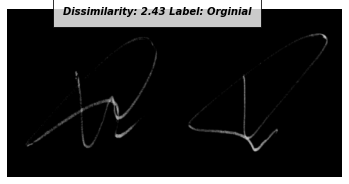

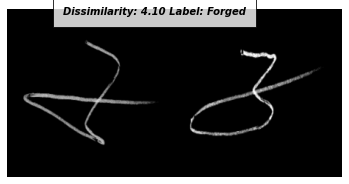

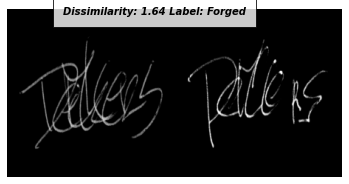

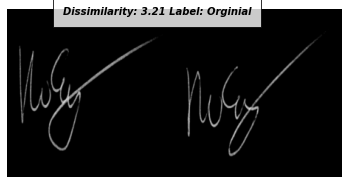

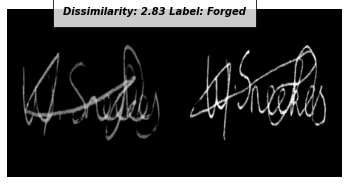

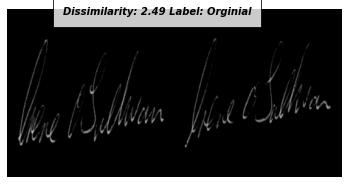

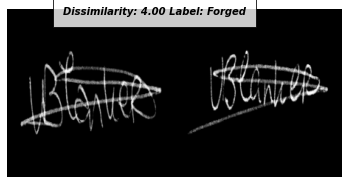

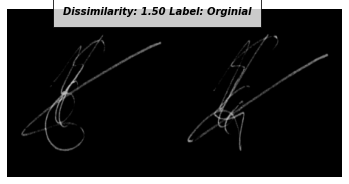

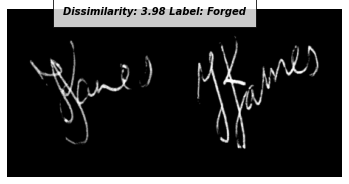

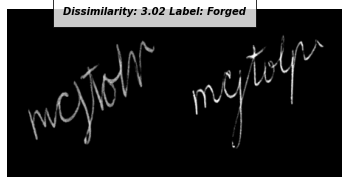

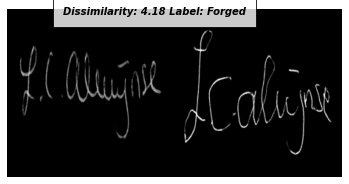

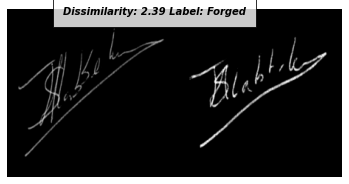

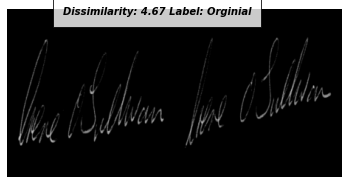

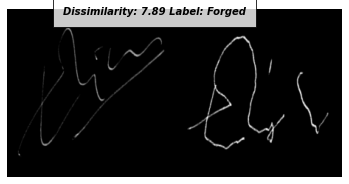

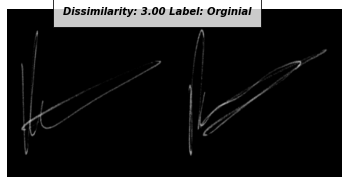

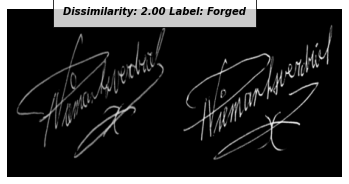

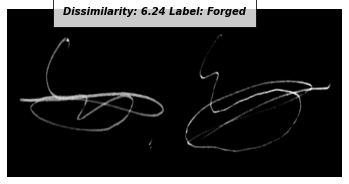

In [37]:
# Print the sample outputs to view its dissimilarity
counter=0
list_0 = torch.FloatTensor([[0]])
list_1 = torch.FloatTensor([[1]])
for i, data in enumerate(test_dataloader,0): 
  x0, x1 , label = data
  concatenated = torch.cat((x0,x1),0)
  output1 = net.inference(x0.to(device))
  output2 = net.inference(x1.to(device))
  eucledian_distance = F.pairwise_distance(output1, output2)
  if label==list_0:
    label="Orginial"
  else:
    label="Forged"
  imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f} Label: {}'.format(eucledian_distance.item(),label))
  counter=counter+1
  if counter ==20:
     break

In [33]:
test_dataset = RandomTripletDataset(training_dir, transform=transform)
test_dataloader = DataLoader(test_dataset, num_workers=6, batch_size=1, shuffle=True)

301it [00:00, 18518.58it/s]
100%|██████████| 300/300 [00:00<00:00, 29383.54it/s]


In [27]:
test_dataset = RandomTripletDataset(testing_dir, transform=transform)
test_dataloader = DataLoader(test_dataset, num_workers=6, batch_size=1, shuffle=True)

129it [00:00, 20109.46it/s]
100%|██████████| 128/128 [00:00<00:00, 46749.47it/s]


In [53]:
for j in np.arange(3,5,1):
    targets = []
    predictions = []
    list_0 = torch.FloatTensor([[0]])
    list_1 = torch.FloatTensor([[1]])
    # threshhold = torch.FloatTensor([50.0]).cuda()
    threshhold = torch.FloatTensor([float(j)]).cuda()
    for i, data in enumerate(tqdm(test_dataloader)):
        x0, x1, x3 = data
        output1, output2, output3 = net(x0.to(device), x1.to(device), x3.to(device))


        eucledian_distance1 = F.pairwise_distance(output1, output2)
        eucledian_distance2 = F.pairwise_distance(output1, output3)
        
        targets.append(0)
        targets.append(1)
        
        if eucledian_distance1 <= threshhold:
            predictions.append(0)
        else:
            predictions.append(1)

        if eucledian_distance2 <= threshhold:
            predictions.append(0)
        else:
            predictions.append(1)

    
    n_predictions = np.array(predictions)
    n_targets = np.array(targets)
    print(f"{j} acc:", (n_predictions == n_targets).astype('int').sum()/len(n_predictions))
    print(f"{j} f1:", f1_score(n_targets, n_predictions, average='weighted'))

0%|          | 0/24093 [00:00<?, ?it/s]


RuntimeError: Expected 4-dimensional input for 4-dimensional weight [64, 3, 7, 7], but got 3-dimensional input of size [3, 224, 224] instead

In [35]:
targets = []
predictions = []
list_0 = torch.FloatTensor([[0]])
list_1 = torch.FloatTensor([[1]])
# threshhold = torch.FloatTensor([50.0]).cuda()
threshhold = torch.FloatTensor([10.0]).cuda()
for i, data in enumerate(tqdm(test_dataloader)):
    x0, x1, x3 = data
    output1, output2, output3 = net(x0.to(device), x1.to(device), x3.to(device))

    eucledian_distance1 = F.pairwise_distance(output1, output2)
    eucledian_distance2 = F.pairwise_distance(output1, output3)
    
    targets.append(0)
    targets.append(1)
    
    if eucledian_distance1 <= threshhold:
        predictions.append(0)
    else:
        predictions.append(1)

    if eucledian_distance2 <= threshhold:
        predictions.append(0)
    else:
        predictions.append(1)

100%|██████████| 150/150 [00:03<00:00, 41.33it/s]


In [235]:
from sklearn.metrics import f1_score

In [236]:
n_predictions = np.array(predictions)
n_targets = np.array(targets)
(n_predictions == n_targets).astype('int').sum()/len(n_predictions)

0.5238095238095238

In [237]:
f1_score(n_targets, n_predictions, average='weighted')

0.38416422287390034

In [238]:
# TPR
n_predictions.astype('int').sum()/np.logical_and((n_predictions == 1.0),(n_targets == 1.0)).astype('int').sum()

1.9523809523809523

In [239]:
# FPR
n_false_predictions = (np.array(predictions) == 0.0).astype('int')
n_false_targets = (np.array(targets) == 0.0).astype('int')
    

In [43]:
# Print the sample outputs to view its dissimilarity
counter=0
list_0 = torch.FloatTensor([[0]])
list_1 = torch.FloatTensor([[1]])
for i, data in enumerate(test_dataloader,0): 
  x0, x1 ,x3 = data
  concatenated1 = torch.cat((x0,x1),0)
  concatenated2 = torch.cat((x0,x3),0)
  output1, output2, output3 = net(x0.to(device), x1.to(device), x3.to(device))
  eucledian_distance1 = F.pairwise_distance(output1, output2)
  eucledian_distance2 = F.pairwise_distance(output1, output3)
  label="Orginial"
  imshow(torchvision.utils.make_grid(concatenated1),'Dissimilarity: {:.2f} Label: {}'.format(eucledian_distance1.item(),label))
  label="Forged"
  imshow(torchvision.utils.make_grid(concatenated2),'Dissimilarity: {:.2f} Label: {}'.format(eucledian_distance2.item(),label))
  counter=counter+1
  if counter ==20:
     break

RuntimeError: Tensors must have same number of dimensions: got 4 and 2